In [1]:
import numpy as np
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

plt.rcParams["figure.dpi"] = 200

In [4]:
GREEDY_SEQUENCE = open("greedy_sequence.txt").read().strip().replace("\n", "").replace("N","")
RANDOM_SEQUENCE = open("random_sequence.txt").read().strip().replace("\n", "").replace("N","")
print(len(GREEDY_SEQUENCE))
print(len(RANDOM_SEQUENCE))

48846420
48846420


In [ ]:
TRAIN_SEQUENCE = open("train_set.txt").read().strip().replace("\n", "").replace("N","")
TEST_SEQUENCE = open("test_set.txt").read().strip().replace("\n", "").replace("N","")

In [10]:
class MarkovChain:
    def __init__(self, n_lookback=1, vocab="ACGT"):
        assert n_lookback > 0

        self.letter_to_idx = {x: i for i, x in enumerate(vocab)}
        self.state_to_idx = {"".join(p): i for i, p in enumerate(itertools.product(vocab, repeat=n_lookback))} # fmt: skip
        self.n_lookback = n_lookback
        self.vocab_size = len(vocab)
        self.vocab = vocab

        m_dim = np.power(self.vocab_size, n_lookback)
        n_dim = self.vocab_size

        self.transition_matrix = np.zeros((m_dim, n_dim), dtype=np.float32)

    def train(self, sequence):
        assert len(sequence) >= self.n_lookback
        for i in range(self.n_lookback, len(sequence)):
            curr_state_idx = self.state_to_idx[sequence[i - self.n_lookback : i]]
            next_state_idx = self.letter_to_idx[sequence[i]]
            self.transition_matrix[curr_state_idx, next_state_idx] += 1.0

        # laplace smoothing, basically to avoid zeros probabilities
        self.transition_matrix += 1.0
        normalization = np.sum(self.transition_matrix, axis=1, keepdims=True)
        self.transition_matrix /= normalization

    def test(self, sequence, method):
        assert len(sequence) >= self.n_lookback
        correct_count = 0

        for i in range(self.n_lookback, len(sequence)):
            curr_state = sequence[i - self.n_lookback : i]
            next_state = sequence[i]
            if self.next_state(curr_state, method= method) == next_state: #where we decide if it's random or greedy
                correct_count += 1
        accuracy = correct_count / (len(sequence) - self.n_lookback)
        print(f"Accuracy: {accuracy:.4f}")

    def next_state(self, current_state, method="random"): #if nothing is passed, it will be random
        assert method in ["random", "greedy"]
        assert len(current_state) == self.n_lookback
        curr_state_idx = self.state_to_idx[current_state]

        if method == "random":
            next_state = np.random.choice(
                self.vocab_size, p=self.transition_matrix[curr_state_idx]
            )
        elif method == "greedy":
            next_state = np.argmax(self.transition_matrix[curr_state_idx])

        return self.vocab[next_state]

Training

In [12]:
n = 11
print(f"markov chain with n_lookback={n}")

start_time = time.perf_counter()

model11th = MarkovChain(n_lookback=n, vocab="ACGT")
model11th.train(TRAIN_SEQUENCE)

end_time = time.perf_counter()
print(f"training time: {end_time-start_time:.6f} seconds")

markov chain with n_lookback=11
training time: 462.249367 seconds


In [13]:
n = 12
print(f"markov chain with n_lookback={n}")

start_time = time.perf_counter()

model12th = MarkovChain(n_lookback=n, vocab="ACGT")
model12th.train(TRAIN_SEQUENCE)

end_time = time.perf_counter()
print(f"training time: {end_time-start_time:.6f} seconds")

markov chain with n_lookback=12
training time: 476.483314 seconds


NOT feeding it's own errors:

We aren't using this though

In [ ]:
def heldout_accurance(model, test_seq, method = "greedy"):
    n = model.n_lookback
    correct = 0
    total = len(test_seq) - n

    for i in range(n, len(test_seq)):
        
        # sliding window changes
        context = test_seq[i-n : i]

        pred = model.next_state(context, method = method)
        
        if pred == test_seq[i]:
            correct += 1

    return correct/total 

Feeding on it's own errors:

Note: Context = the last n symbols we are feeding into the chain to predict the next one

The best model for greedy was 11 and for random was 12!

In [15]:
def generate_and_evaluate(model, test_seq, method = "greedy"):
    n = model.n_lookback

    context = test_seq[:n]
    correct = 0
    total = len(test_seq) - n

    for i in range (n, len(test_seq)):
        pred = model.next_state(context, method = method)

        if pred == test_seq[i]:
            correct += 1

        context = context[1:] + pred
    
    return correct/total

t0 = time.perf_counter()
greedy_acc = generate_and_evaluate(model11th, TEST_SEQUENCE, method = "greedy")
t1 = time.perf_counter()
# HAD TO FIX TO BE MODEL 12 FOR RANDOM
random_acc = generate_and_evaluate(model12th, TEST_SEQUENCE, method = "random")
t2 = time.perf_counter()
print(f" greedy accuracy = {greedy_acc:.4f}, time: {t1-t0:.6f} seconds")
print(f" random accuracy = {random_acc:.4f}, time: {t2-t1:.6f} seconds")


 greedy accuracy = 0.2479, time: 148.735388 seconds
 random accuracy = 0.2549, time: 1340.640692 seconds


In [25]:
def generate_and_evaluate(model, test_seq, method="greedy"):
	n = model.n_lookback
	context = test_seq[:n]
	correct = 0
	total = len(test_seq) - n
	generated = context  # start with the initial prefix

	for i in range(n, len(test_seq)):
		pred = model.next_state(context, method=method)
		generated += pred  # build the full generated sequence
		if pred == test_seq[i]:
			correct += 1
			context = context[1:] + pred

	accuracy = correct / total
	return accuracy, generated


In [26]:
t0 = time.perf_counter()
greedy_acc, greedy_seq = generate_and_evaluate(model11th, TEST_SEQUENCE, method="greedy")
t1 = time.perf_counter()

random_acc, random_seq = generate_and_evaluate(model12th, TEST_SEQUENCE, method="random")
t2 = time.perf_counter()

print(f"greedy accuracy = {greedy_acc:.4f}, time: {t1-t0:.6f} seconds")
print(f"random accuracy = {random_acc:.4f}, time: {t2-t1:.6f} seconds")

greedy accuracy = 0.2191, time: 245.904518 seconds
random accuracy = 0.2640, time: 1410.746473 seconds


In [ ]:
# Save greedy sequence
with open("greedy_sequence.txt", "w") as f:
	f.write(greedy_seq)

# Save random sequence
with open("random_sequence.txt", "w") as f:
	f.write(random_seq)

Sanity Check:

In [16]:
# number of states
num_states = model11th.transition_matrix.shape[0]
print(num_states)
print(4**11)
# 4**11

4194304
4194304


In [17]:
# how big our transition matrix is
print(model11th.transition_matrix.nbytes)
print(model11th.transition_matrix.dtype)

67108864
float32


Perplexity

I need to have a better mathematical understanding of perplexity

In [ ]:
import math

def compute_perplexity(model, sequence):
    N = model.n_lookback
    log2_prob_sum = 0 
    T = len(sequence) - N
    for i in range(N, len(sequence)):
        context = sequence[i-N:i]
        true_base = sequence[i]
        ctx_idx = model.state_to_idx[context]
        base_idx = model.letter_to_idx[true_base]
        p = model.transition_matrix[ctx_idx, base_idx]

        # for tiny rounding zeros

        log2_prob_sum += math.log2(p if p > 0 else 1e-12)
    
    H = -log2_prob_sum/T # bits per symbol (cross entropy)
    return 2**H # pp

# pp = compute_perplexity(model11th, TEST_SEQUENCE)
# print(f"perplexity for n = 11 model: {pp:.2f}")

pp = compute_perplexity(model11th, TEST_SEQUENCE)
print(f"perplexity for n = 11 model: {pp:.2f}")
pp = compute_perplexity(model12th, TEST_SEQUENCE)
print(f"perplexity for n = 12 model: {pp:.2f}")

# oops i should've saved it with different variable names

perplexity for n = 11 model: 3.42
perplexity for n = 12 model: 3.46


Sanity check part two

In [19]:
# bug found oops, the rows don't add up to one in my class saved transition matrix
# the transition matrix of model11th was off??? maybe is because i ran the code yesterday
row_sums = model11th.transition_matrix.sum(axis = 1)
print(row_sums.min(), row_sums.max())
# float imprecision error makes it 0.9999999 1.0000001
row_sums = model12th.transition_matrix.sum(axis = 1)
print(row_sums.min(), row_sums.max())

0.9999999 1.0000001
0.9999999 1.0000001


Should I make this graph, I don't think I can retrain n = 14 again, 15 hours...

In [ ]:
print(list(range(1,15)))

# i don't think i am going to include 14

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


Think I am going to run this over-night maybe?

In [ ]:
import matplotlib.pyplot as plt

# have to retrain everything again
orders = list(range(1,14))
perps = []
for n in orders:
    m = MarkovChain(n_lookback = n , vocab = "ACGT")
    m.train(TRAIN_SEQUENCE)
    perps.append(compute_perplexity(m, TEST_SEQUENCE))

# plot perplexity
plt.figure(figsize = (8,4))
plt.plot(orders, perps, marker = 'o')
plt.xticks(orders)
plt.xlabel("Markov Order (n)")
plt.ylabel("Perplexity")
plt.title("Perplexity vs. Markov Order")
plt.grid(True)
plt.tight_layout()
plt.show()

Graphs, Graphs, Graphs;

This one is the rather basic information we can extract (using training time, random time and accuracy, and greedy time and accuracy)
Not sure if we should use the trianing time (matter of space on poster)

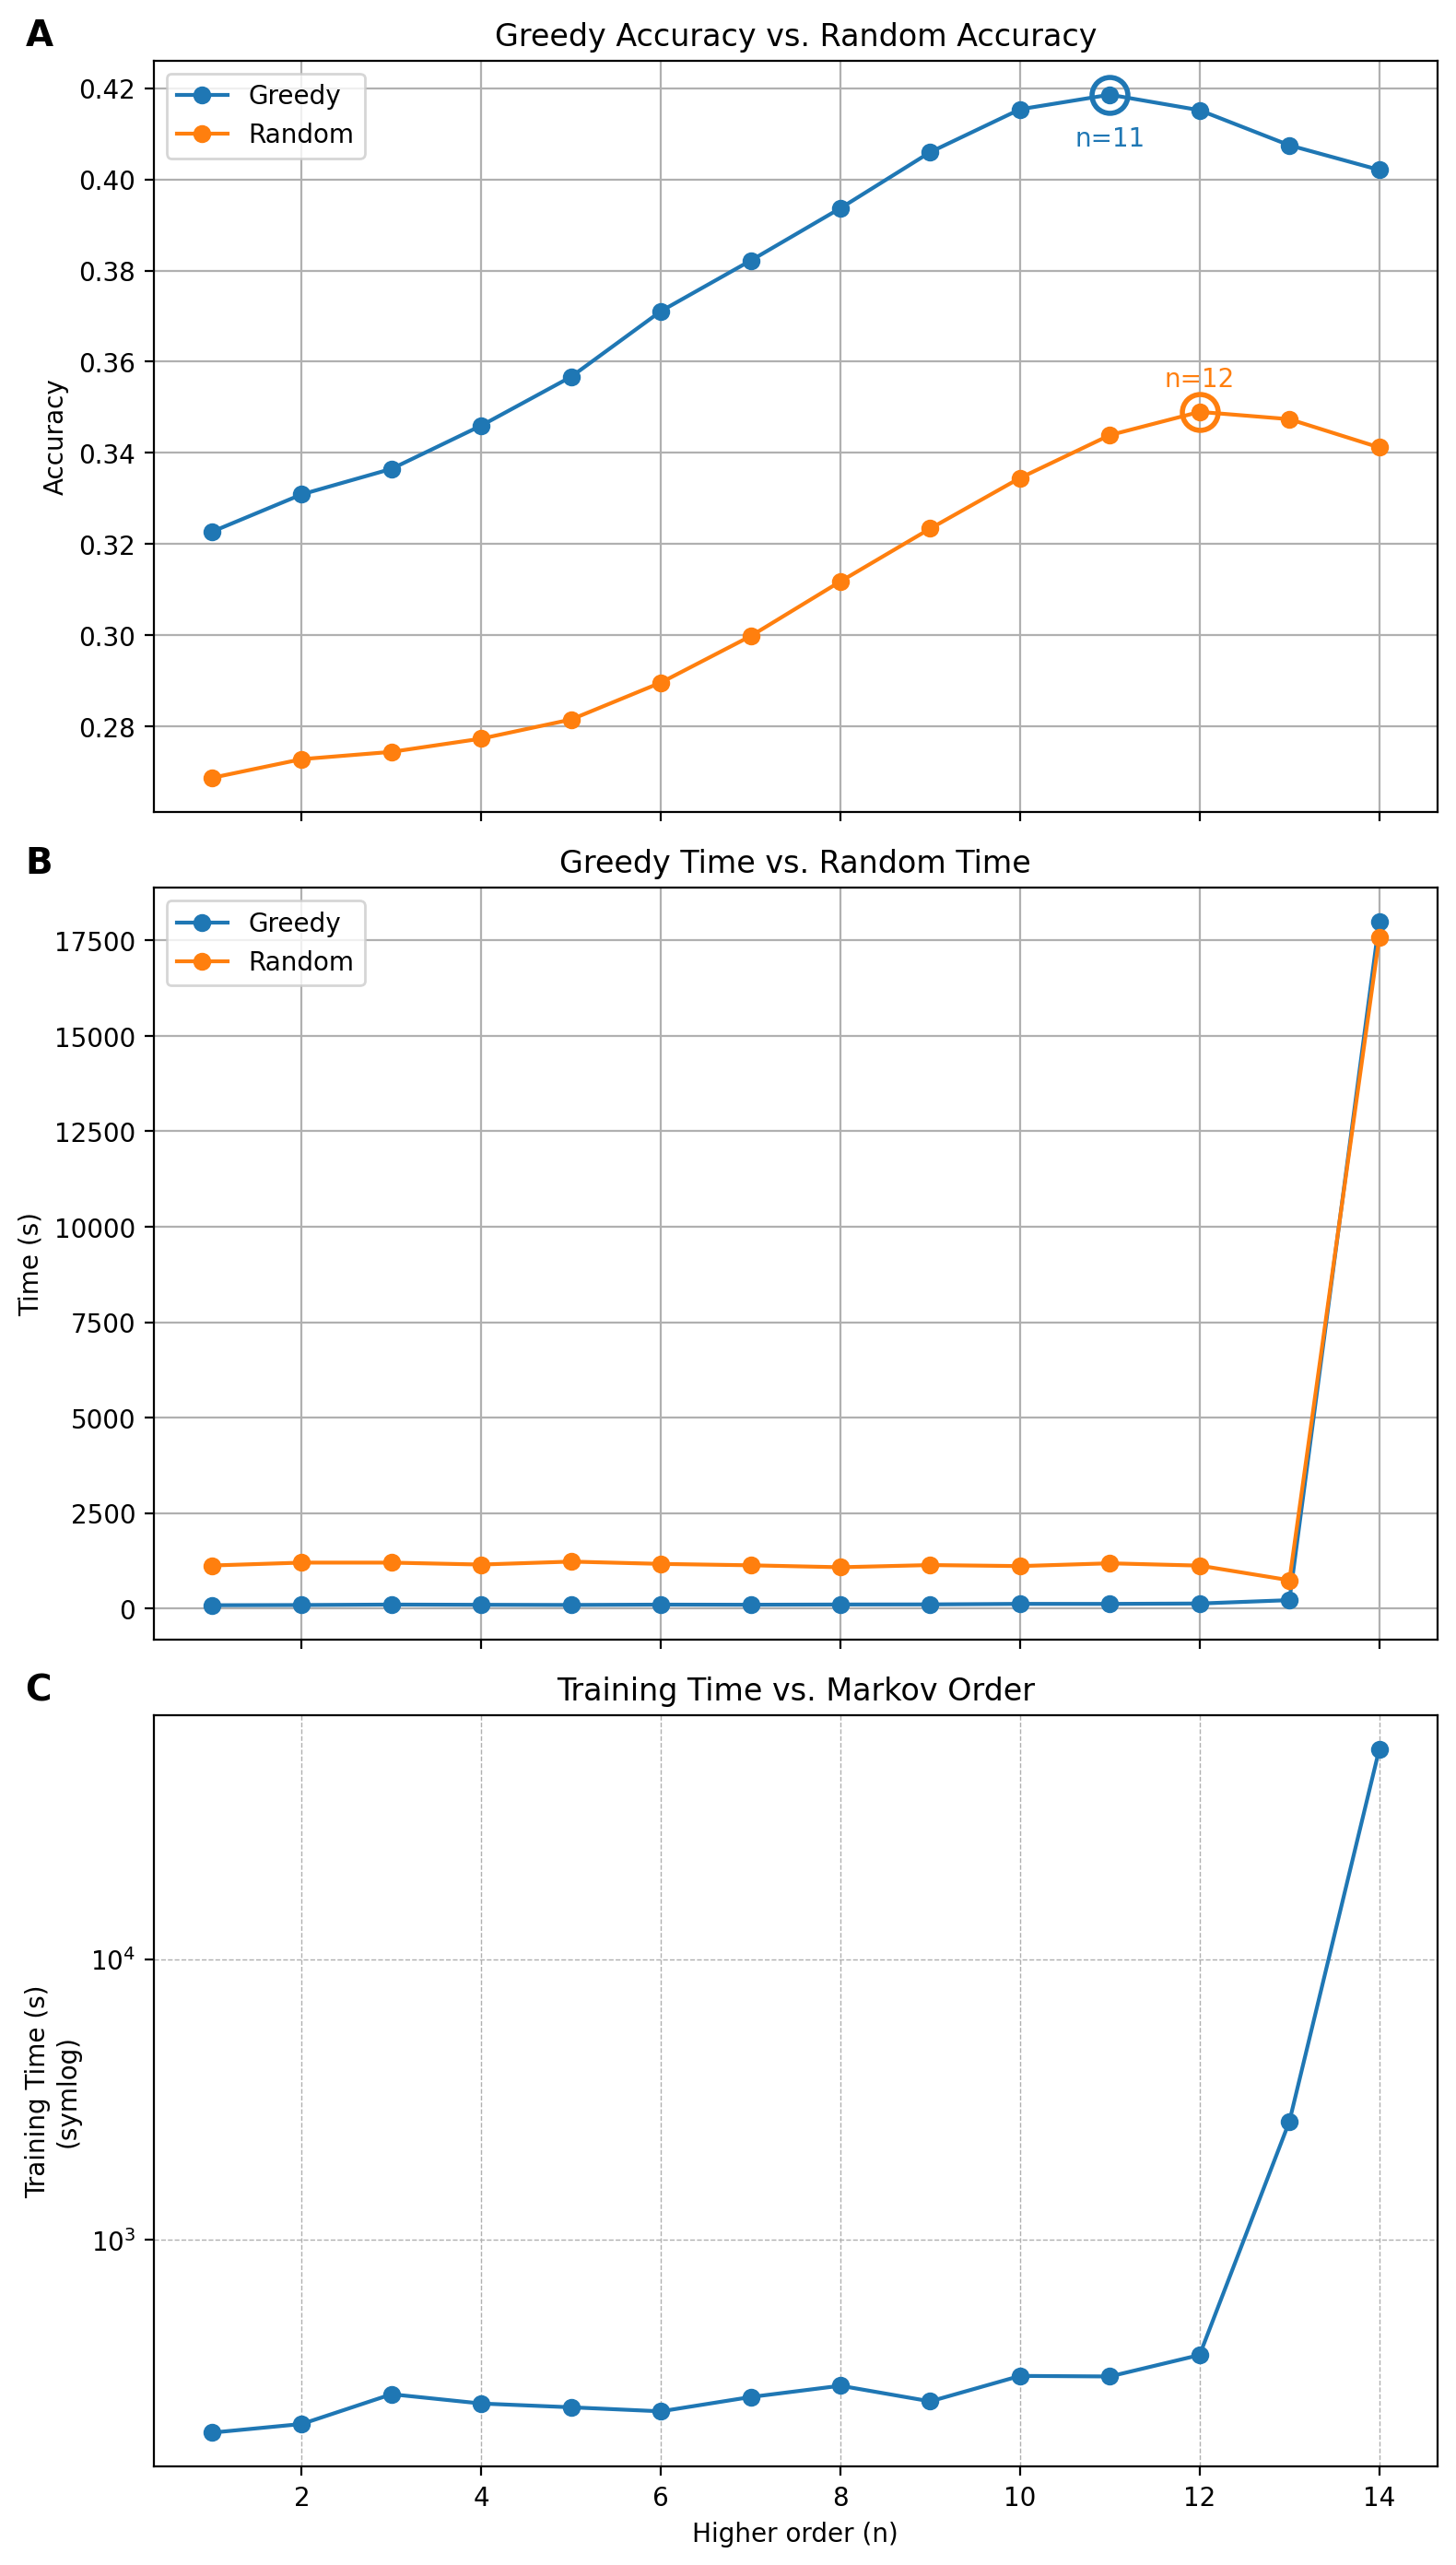

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
# data for n=1 to n=14
n = np.arange(1, 15)
greedy_acc = np.array([0.3227, 0.3309, 0.3365, 0.3460, 0.3567, 0.3711, 0.3822,  
                   	0.3937, 0.4060, 0.4154, 0.4186, 0.4152, 0.4075, 0.4021])

random_acc = np.array([0.2687, 0.2728, 0.2744, 0.2773, 0.2815, 0.2896, 0.2998,  
                   	0.3118, 0.3234, 0.3345, 0.3439, 0.3490, 0.3474, 0.3412])

greedy_time = np.array([85.048331, 90.618003, 102.470040, 96.647125, 92.564059,  
                    	100.838103, 97.841454, 103.818538, 106.809791, 121.079561,  
                    	120.255649, 130.246325, 218.580150, 17981.015668])
random_time = np.array([1125.965898, 1201.684862, 1201.236312, 1150.895517,  
                    	1228.239511, 1167.986255, 1131.172991, 1080.327514,  
                    	1137.700348, 1110.646820, 1183.522887, 1123.140312,  
                    	740.219882, 17571.955664])
training_time = np.array([326.265140, 340.125438, 387.861351, 372.971147,  
                      	366.911447, 360.438810, 383.395805, 401.497911,  
                      	376.428118, 417.244455, 416.361439, 450.780593,  
                      	2644.825032, 55960.794100])
 
# three subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 14), sharex=True)
 
# panel A: Greedy vs. Random Accuracy with peaks highlighted
ax = axes[0]
ax.plot(n, greedy_acc, marker='o', label='Greedy', color='C0')
ax.plot(n, random_acc, marker='o', label='Random', color='C1')
i_g = np.argmax(greedy_acc)
i_r = np.argmax(random_acc)
# highlight peaks
ax.plot(n[i_g], greedy_acc[i_g],
     	marker='o', markersize=14, markerfacecolor='none',
     	markeredgecolor='C0', markeredgewidth=2)
ax.plot(n[i_r], random_acc[i_r],
     	marker='o', markersize=14, markerfacecolor='none',
     	markeredgecolor='C1', markeredgewidth=2)
# annotate peak n values
ax.annotate(f'n={n[i_g]}', (n[i_g], greedy_acc[i_g]),
         	textcoords="offset points", xytext=(0, -20), ha='center', color='C0')
ax.annotate(f'n={n[i_r]}', (n[i_r], random_acc[i_r]),
         	textcoords="offset points", xytext=(0, 10), ha='center', color='C1')
ax.set_ylabel('Accuracy')
ax.set_title('Greedy Accuracy vs. Random Accuracy')
ax.legend()
ax.grid(True)
ax.text(-0.1, 1.02, 'A', transform=ax.transAxes, fontsize=14, fontweight='bold')
 
# panel B: Greedy vs. Random Time (linear)
ax = axes[1]
ax.plot(n, greedy_time, marker='o', label='Greedy', color='C0')
ax.plot(n, random_time, marker='o', label='Random', color='C1')
ax.set_ylabel('Time (s)')
ax.set_title('Greedy Time vs. Random Time')
ax.legend()
ax.grid(True)
ax.text(-0.1, 1.02, 'B', transform=ax.transAxes, fontsize=14, fontweight='bold')
 
# panel C: Training Time vs. Markov Order (symlog scale)
ax = axes[2]
ax.plot(n, training_time, marker='o', color='C0')
ax.set_yscale('symlog', linthresh=500)
ax.set_xlabel('Higher order (n)')
ax.set_ylabel('Training Time (s)\n(symlog)')
ax.set_title('Training Time vs. Markov Order')
ax.grid(True, which='both', ls='--', lw=0.5)
ax.text(-0.1, 1.02, 'C', transform=ax.transAxes, fontsize=14, fontweight='bold')
 
plt.tight_layout()
plt.show()
